<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#BKK-Data" data-toc-modified-id="BKK-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>BKK Data</a></span></li><li><span><a href="#Map" data-toc-modified-id="Map-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Map</a></span></li><li><span><a href="#Fire-Feature-V.2" data-toc-modified-id="Fire-Feature-V.2-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fire Feature V.2</a></span><ul class="toc-item"><li><span><a href="#Obtaining-Wind-Vectors" data-toc-modified-id="Obtaining-Wind-Vectors-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Obtaining Wind Vectors</a></span></li><li><span><a href="#Damping-Factor-Due-to-Wind-Direction" data-toc-modified-id="Damping-Factor-Due-to-Wind-Direction-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Damping Factor Due to Wind Direction</a></span></li><li><span><a href="#Calculate-the-arrival-time" data-toc-modified-id="Calculate-the-arrival-time-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Calculate the arrival time</a></span></li></ul></li><li><span><a href="#Trainer-Object" data-toc-modified-id="Trainer-Object-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Trainer Object</a></span></li><li><span><a href="#Train-Model" data-toc-modified-id="Train-Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train Model</a></span><ul class="toc-item"><li><span><a href="#Train-PM2.5" data-toc-modified-id="Train-PM2.5-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Train PM2.5</a></span></li><li><span><a href="#Train--PM2.5-with-Traffic" data-toc-modified-id="Train--PM2.5-with-Traffic-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Train  PM2.5 with Traffic</a></span></li><li><span><a href="#Train-PM10" data-toc-modified-id="Train-PM10-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Train PM10</a></span></li><li><span><a href="#Train-O3" data-toc-modified-id="Train-O3-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Train O3</a></span></li><li><span><a href="#Train-NO2" data-toc-modified-id="Train-NO2-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Train NO2</a></span></li><li><span><a href="#TPOP-PM10" data-toc-modified-id="TPOP-PM10-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>TPOP PM10</a></span></li></ul></li></ul></div>

In [1]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.gen_functions import *
from src.features.dataset import Dataset
from src.features.build_features import *
from src.models.train_model import *
from src.visualization.vis_data import *
import seaborn as sns
output_notebook()
plt.rcParams.update({'font.size': 14})

Loading BokehJS ...

# BKK Data 

In [110]:
# start building dataset from scratch only perform this when new data files are added 
dataset = Dataset('Bangkok')
dataset.build_all_data( build_fire=True, build_holiday = True)

save file ../data/bangkok/02t.csv
save file ../data/bangkok/03t.csv
save file ../data/bangkok/05t.csv
save file ../data/bangkok/11t.csv
save file ../data/bangkok/12t.csv
save file ../data/bangkok/50t.csv
save file ../data/bangkok/52t.csv
save file ../data/bangkok/53t.csv
save file ../data/bangkok/59t.csv
save file ../data/bangkok/61t.csv
Averaging data from 11 stations
Loading all hotspots data. This might take sometimes
before drop (3168630, 18)
after drop (3064842, 10)


In [3]:
# reinit the data and load saved process data 
dataset = Dataset('Bangkok')
dataset.load_()
# merge pollution data with other data except fire
dataset.feature_no_fire()

data no fire has shape (53388, 14)


Index(['PM2.5', 'PM10', 'O3', 'CO', 'NO2', 'SO2'], dtype='object')


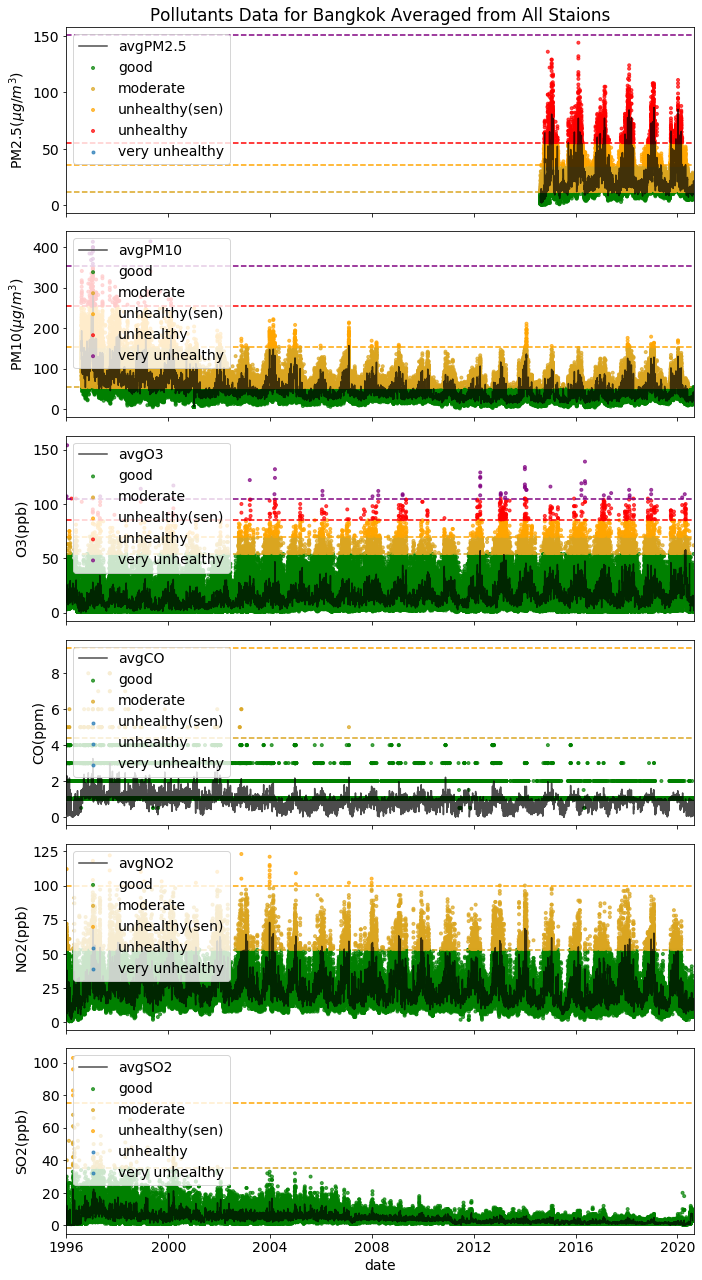

In [3]:
# plot the raw data
plot_all_pollutions(dataset.poll_df, city_name=dataset.city_name)

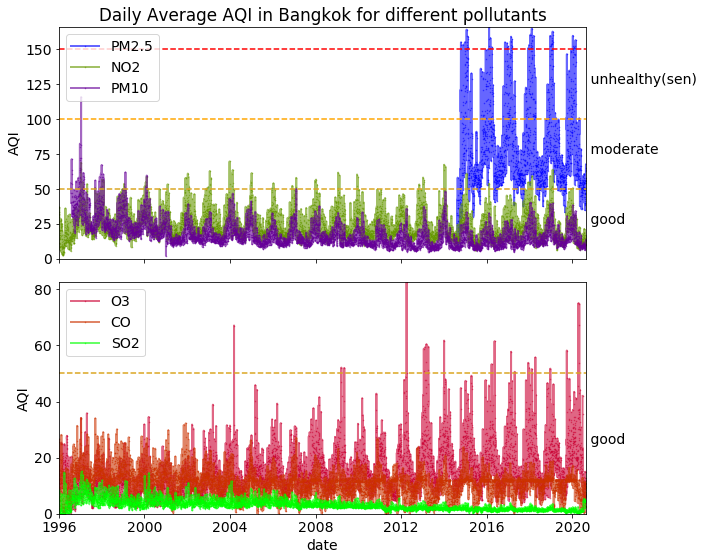

In [4]:
plot_polls_aqi(dataset.poll_df.copy(), dataset.roll_dict, dataset.city_name, filename=dataset.report_folder + 'all_pol_aqi.png' )

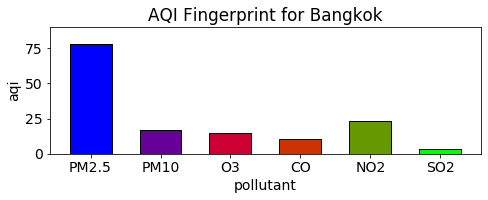

In [6]:
plot_chem_print(poll_to_aqi(dataset.poll_df.copy(), dataset.roll_dict).mean(axis=0), dataset.city_name, filename=dataset.report_folder + 'fingerprint.png')

aqi 100 in  11-05 to 03-28


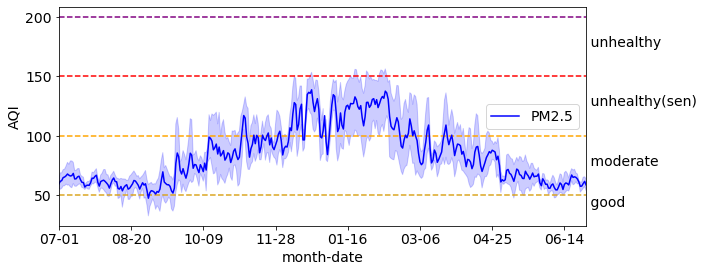

In [5]:
plot_season_aqi(dataset.poll_df.copy(), dataset.roll_dict, 'PM2.5', filename=dataset.report_folder + 'seasonal_pattern_PM25.png')

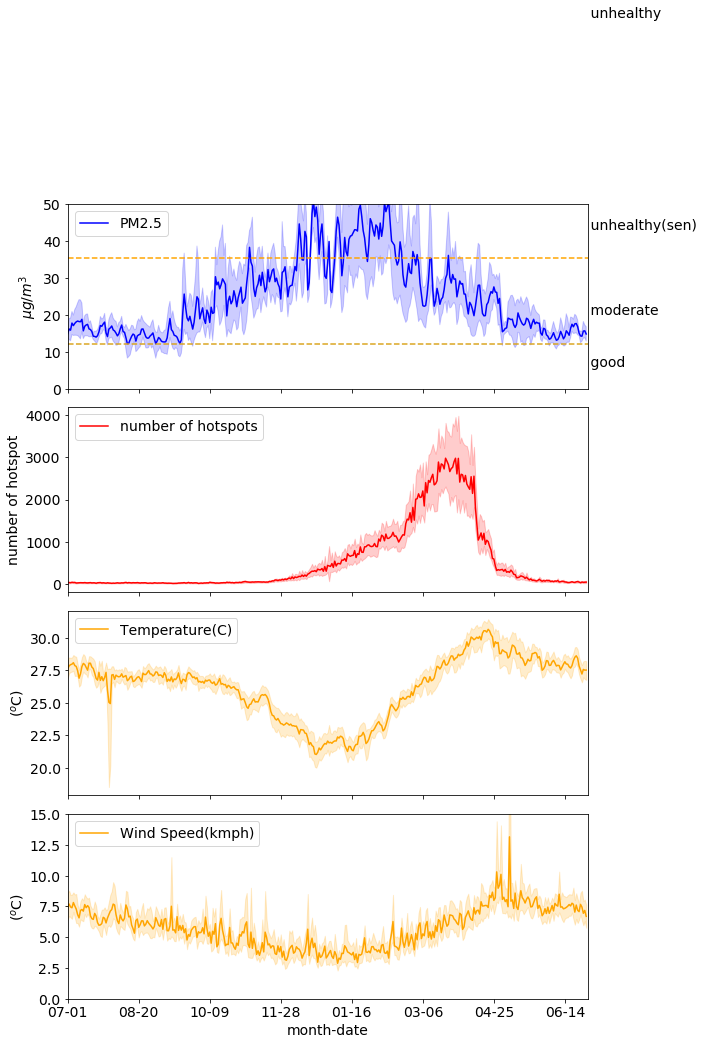

In [9]:
ax = compare_seson_avg(dataset, agg='mean')
ax[0].set_ylim([0, 55])
ax[3].set_ylim([0,15])

plt.savefig(dataset.report_folder + 'fire_PM25_season.png')

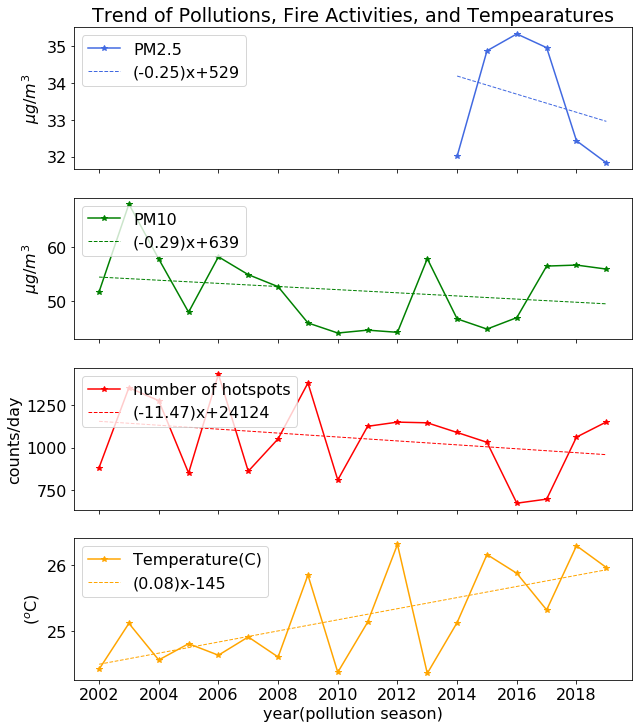

In [331]:
ax, year_avg = plot_yearly_ln(dataset, start_month='-11-01', end_month='-03-31', filename=dataset.report_folder + 'compare_ln_trends.png')

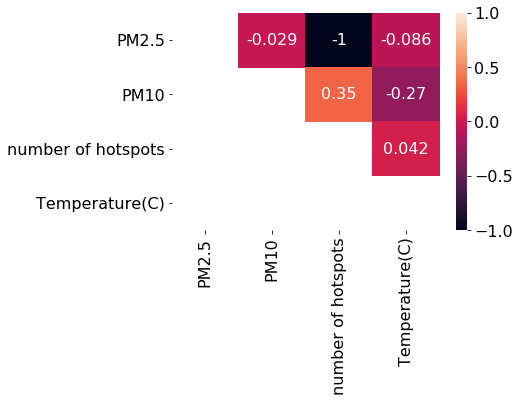

In [332]:
plot_corr(year_avg, figsize=(6,4))

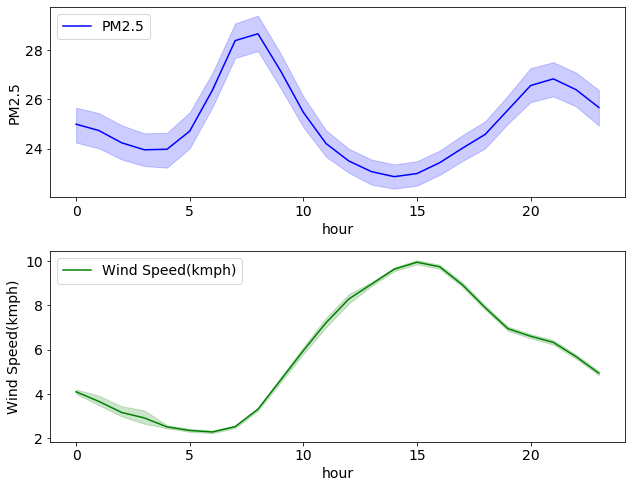

In [19]:
_, ax = plt.subplots(2, 1, figsize=(9, 7))
plot_hour_avg(dataset.poll_df.copy(), 'PM2.5', ax[0],  color='blue')
plot_hour_avg(dataset.wea.copy(), 'Wind Speed(kmph)', ax[1],  color='green')
plt.tight_layout()

# Map

In [4]:
dataset.city_info

x = merc_x(dataset.city_info['Longitude'])
y = merc_y(dataset.city_info['Latitude'])
#stepx = 2E5

stepx = 1E6
stepy = stepx

In [13]:
# select fire data 
fire = dataset.fire
i = 0
month_list = ['2019-03','2019-04']
month = month_list[i]
color = 'red'
fire1 = fire.loc[month:month_list[i+1]]

month_list = ['2018-12','2019-01']
month = month_list[i]
fire2 = fire.loc[month:month_list[i+1]]

In [14]:
# range bounds supplied in web mercator coordinates
p = figure(x_range=(x-0.5*stepx,x+0.5*stepx), y_range=(y-stepy*0.1, y+stepy*0.0001),
           x_axis_type="mercator", y_axis_type="mercator",
          title = dataset.city_name)
p.add_tile(get_provider(Vendors.STAMEN_TERRAIN_RETINA))

# add city center
p.scatter(x,y,color='red',line_color='black',size=10, legend_label=dataset.city_name)

# plot hotspots at the begining and end of winter season

p.scatter(fire1['long_km']*1000,fire1['lat_km']*1000,color='red',size=1, alpha=0.5,legend_label='fire in Mar 2019')

p.scatter(fire2['long_km']*1000,fire2['lat_km']*1000,color='blue',size=1, alpha=0.5, legend_label='fire in Dec 2018')

#add circles
labels = ['0-100km','100-200km','200-400km','400-600km']

rs = [100, 200, 400, 600]
rs.reverse()
colors = get_color(color_length=len(labels),cmap=cm.jet)
for i, (r, label, color) in enumerate(zip(rs, labels, colors)):
    if i ==3 or i ==2:
        alpha=0.4
    else:
        alpha=0.2
        
    xy = get_circle(x,y,r=r*1E3)
    p.patch(xy[0,:],xy[1,:],alpha=alpha,line_width=2,line_color='black',color=color, legend_label=label)
    
p.legend.location = "bottom_right"

show(p)

# Fire Feature V.2

In [8]:
from bokeh.models import Arrow, NormalHead, VeeHead

In [33]:
# reinit the data and load saved process data 
dataset = Dataset('Bangkok')
dataset.load_()
# merge pollution data with other data except fire
dataset.feature_no_fire()

data no fire has shape (53424, 14)


In [9]:
dataset.city_info

{'Country': 'Thailand',
 'City': 'Bangkok',
 'City (ASCII)': 'Bangkok',
 'Region': 'Bangkok',
 'Region (ASCII)': 'Bangkok',
 'Population': '5104476',
 'Latitude': '13.754',
 'Longitude': '100.5014',
 'Time Zone': 'Asia/Bangkok',
 'lat_km': 1536.0,
 'long_km': 11188.0}

In [10]:
# obtain the city center in km
city_x = dataset.city_info['long_km'] 
city_y = dataset.city_info['lat_km'] 

print(city_x, city_y)
city_x = city_x*1E3
city_y = city_y*1E3

11188.0 1536.0


In [11]:
# pick a hotspot
row = dataset.fire.iloc[47]
spot_x = row['long_km']*1E3
spot_y = row['lat_km']*1E3

I need to conver the 2D hotspots data into a column data. In the earlier version, I assume that every hotspot travels to the city at an average wind speed. In a different part of the code, I also add a damping factor of (1/distance square) to lessen the contribution form hotspots, which are far away. This approach works alright for Chiang Mai, which has mostly calm wind property. But most cities are by the ocean with dynamic wind direction. In this version, I try to account for damping factor due to the wind direction. This is still challenging without detail historical wind map. Using the average wind direction of the city center of the same day. The satellite only takes data once a day so only the average value is needed. The damping factor is the calculated from the dot product between the hotspot vector and the wind direction vector. The figure below shows a hotspot vector for one hotspot.  

In [12]:
# set the size of the map 
stepx = 2E5
stepy = stepx


# range bounds supplied in web mercator coordinates
p = figure(x_range=(city_x-stepx,city_x+1.2*stepx), y_range=(city_y-stepy*0.5, city_y+stepy*0.0001),
           x_axis_type="mercator", y_axis_type="mercator",
          title = 'Hotspot Vector')

p.add_tile(get_provider(Vendors.STAMEN_TERRAIN_RETINA))

p.scatter(city_x, city_y ,color='blue',line_color='black',size=10, legend_label='city_center')

p.scatter(spot_x ,spot_y ,color='red',line_color='black',size=10, legend_label='hotspot')


p.add_layout(Arrow(end=VeeHead(size=10), line_color="red",
                   x_start=spot_x, y_start=spot_y, x_end=city_x, y_end=city_y))

show(p)

## Obtaining Wind Vectors

I need to convert the string wind direction to a unit vector in Cartesian coordinates. This is done by using the compass definition.

In [177]:
# obtain the compass to degree conversion 
compass = pd.read_html('https://www.campbellsci.com/blog/convert-wind-directions')[0]
compass = compass.drop_duplicates('Compass Sectors')
# obtain the index
cardinal_var = compass['Values'].values

# convert to cartesian coordinate
# East is zero degree
degs = (cardinal_var - 1)*22.5 - 90
# add a unit vector 
wind_vec_x = [np.cos(np.radians(deg)).round(2) for deg in degs]
wind_vec_y = [np.sin(np.radians(deg)).round(2) for deg in degs]

compass['wind_vec_x'] = wind_vec_x
compass['wind_vec_y'] = wind_vec_y

# check if the direction is correct
# S means the wind is blowing from the south, so this is correct 
compass

Values Compass Sectors  wind_vec_x  wind_vec_y
0        1               N        0.00       -1.00
1        2             NNE        0.38       -0.92
2        3              NE        0.71       -0.71
3        4             ENE        0.92       -0.38
4        5               E        1.00        0.00
5        6             ESE        0.92        0.38
6        7              SE        0.71        0.71
7        8             SSE        0.38        0.92
8        9               S        0.00        1.00
9       10             SSW       -0.38        0.92
10      11              SW       -0.71        0.71
11      12             WSW       -0.92        0.38
12      13               W       -1.00        0.00
13      14             WNW       -0.92       -0.38
14      15              NW       -0.71       -0.71
15      16             NNW       -0.38       -0.92

In [114]:
# create a dictionary that map wind direction to its vector 
wind_vec_x_dict = {}
wind_vec_y_dict = {}

for i, row in compass.iterrows():
    wind_vec_x_dict[row['Compass Sectors']] = row['wind_vec_x']
    wind_vec_y_dict[row['Compass Sectors']] = row['wind_vec_y']

print(wind_vec_x_dict)
print(wind_vec_y_dict)

{'N': 0.0, 'NNE': 0.38, 'NE': 0.71, 'ENE': 0.92, 'E': 1.0, 'ESE': 0.92, 'SE': 0.71, 'SSE': 0.38, 'S': 0.0, 'SSW': -0.38, 'SW': -0.71, 'WSW': -0.92, 'W': -1.0, 'WNW': -0.92, 'NW': -0.71, 'NNW': -0.38}
{'N': -1.0, 'NNE': -0.92, 'NE': -0.71, 'ENE': -0.38, 'E': 0.0, 'ESE': 0.38, 'SE': 0.71, 'SSE': 0.92, 'S': 1.0, 'SSW': 0.92, 'SW': 0.71, 'WSW': 0.38, 'W': 0.0, 'WNW': -0.38, 'NW': -0.71, 'NNW': -0.92}


In [123]:
wind_vec_x_dict = {'N': 0.0, 'NNE': 0.38, 'NE': 0.71, 'ENE': 0.92, 'E': 1.0, 'ESE': 0.92, 'SE': 0.71, 'SSE': 0.38, 'S': 0.0, 'SSW': -0.38, 'SW': -0.71, 'WSW': -0.92, 'W': -1.0, 'WNW': -0.92, 'NW': -0.71, 'NNW': -0.38}
wind_vec_y_dict = {'N': -1.0, 'NNE': -0.92, 'NE': -0.71, 'ENE': -0.38, 'E': 0.0, 'ESE': 0.38, 'SE': 0.71, 'SSE': 0.92, 'S': 1.0, 'SSW': 0.92, 'SW': 0.71, 'WSW': 0.38, 'W': 0.0, 'WNW': -0.38, 'NW': -0.71, 'NNW': -0.92}

In [154]:
# convert the wind direction to vector 
wea_proc = dataset.wea.copy()
# create a winvector columns
wea_proc['wind_vec_x'] =  wea_proc['Wind'].map(wind_vec_x_dict)
wea_proc['wind_vec_y'] =  wea_proc['Wind'].map(wind_vec_y_dict)
# rolling average smooth abrupt change
wea_proc = wea_proc.rolling(6, min_periods=1).mean()
# reample to daily average
wea_proc = wea_proc.resample('d').mean()

# normalize wind vector 
norm_vec = np.linalg.norm(wea_proc[['wind_vec_x', 'wind_vec_y']].values, axis=1)
wea_proc['wind_vec_x'] = wea_proc['wind_vec_x']/norm_vec
wea_proc['wind_vec_y'] = wea_proc['wind_vec_y']/norm_vec
wea_proc = wea_proc[['Wind Speed(kmph)','wind_vec_x','wind_vec_y']]

## Damping Factor Due to Wind Direction

In [24]:
def add_wea_vec(wea_df:pd.DataFrame)-> pd.DataFrame:
    """Add wind direction vector columns. This is to prepare the weather data for fire feature engineering.
    
    
    Args:
        wea_df: weather dataframe with datetime index 'Wind' and 'Wind Speed(kmph)' columns
        
    Returns: process weather dataframe
    

    """
    # dictionay to map the string direction 
    wind_vec_x_dict = {'N': 0.0, 'NNE': 0.38, 'NE': 0.71, 'ENE': 0.92, 'E': 1.0, 'ESE': 0.92, 'SE': 0.71, 'SSE': 0.38,
                       'S': 0.0, 'SSW': -0.38, 'SW': -0.71, 'WSW': -0.92, 'W': -1.0, 'WNW': -0.92, 'NW': -0.71, 'NNW': -0.38}
    wind_vec_y_dict = {'N': -1.0, 'NNE': -0.92, 'NE': -0.71, 'ENE': -0.38, 'E': 0.0, 'ESE': 0.38, 'SE': 0.71,
                       'SSE': 0.92, 'S': 1.0, 'SSW': 0.92, 'SW': 0.71, 'WSW': 0.38, 'W': 0.0, 'WNW': -0.38, 'NW': -0.71, 'NNW': -0.92}
    
    # keep only wind direction and wind speed columns
    wea_proc = wea_df[['Wind', 'Wind Speed(kmph)']].copy()
    # create a winvector columns
    wea_proc['wind_vec_x'] =  wea_proc['Wind'].map(wind_vec_x_dict)
    wea_proc['wind_vec_y'] =  wea_proc['Wind'].map(wind_vec_y_dict)
    # rolling average smooth abrupt change. 
    wea_proc = wea_proc.rolling(6, min_periods=1).mean()
    # reample to daily average because the fire data is a daily data 
    wea_proc = wea_proc.resample('d').mean().round()
    # normalize wind vector 
    norm_vec = np.linalg.norm(wea_proc[['wind_vec_x', 'wind_vec_y']].values, axis=1)
    wea_proc['wind_vec_x'] = wea_proc['wind_vec_x']/norm_vec
    wea_proc['wind_vec_y'] = wea_proc['wind_vec_y']/norm_vec
    
    # drop the 'Wind' direction columns
    return wea_proc

In [43]:
def cal_wind_damp_row(row, city_x, city_y):
    """Calculate damping factor for each hotspot. This function should be applied to Panda DataFrame.
    
    Round to negative damping factor to zero.
    
    Args:
        row: panda row
        city_x: longitude in km in Mercator coordinate
        city_y: latitude in km in Mercator coordinate
        
    Return: float 
        a damping factor for that row.
        
    """
    # forming a vector in km unit 
    hot_vec = [(city_x - row['long_km']), (city_y - row['lat_km'])]
    # normalize this vector
    hot_vec = hot_vec/np.linalg.norm(hot_vec)
 
    wea_vec = [row['wind_vec_x'], row['wind_vec_y']]
     
    # round to zero and keep only the value greater than or equal to two
    return np.maximum(round(np.dot(hot_vec, wea_vec), 4), 0)

In [44]:
def cal_wind_damp(fire_df, wea_df, city_x, city_y):
    """Calculate the damping due to the wind direction. The new column is named 'winddamp' columns
    
    Args:
        fire_df: hotspots information
        wea_df: weather dataframe 
        city_x: longitude in km in Mercator coordinate
        city_y: latitude in km in Mercator coordinate
        
    Returns:   pd.DataFrame
    
    """
    fire_df['round_time'] = fire_df.index.round('D')
    # obtain process weather dataframe
    wea_proc = add_wea_vec(wea_df)
    # add windspeed and direction to the fire data
    fire_df = fire_df.merge(wea_proc, left_on='round_time', right_index=True, how='left')    
    # calculate the damping factors due to win direction
    fire_df['winddamp'] = fire_df.apply(cal_wind_damp_row, axis=1, args=(city_x, city_y))
    # keep only the columns with more than zero winddamp factor to reduce computation time
    fire_df = fire_df[fire_df['winddamp'] > 0]


    #remove unuse columns
    return fire_df.drop(['wind_vec_x', 'wind_vec_y', 'round_time'], axis=1)

In [45]:
# testing wind damping function
fire_df = dataset.fire.copy()
wea_df = dataset.wea
fire_col = 'power'
damp_surface = 'sphere'
# obtain the city center in km
city_x = dataset.city_info['long_km'] 
city_y = dataset.city_info['lat_km'] 

fire_df = cal_wind_damp(fire_df, wea_df, city_x, city_y)

## Calculate the arrival time 

The each hotspot also has different arrival time to the city. In the earlier version, I also use a single average value. Here, I include that option to use the wind speed in kmph and the distance from the city to calculate the arrival time to city.

`features.build_features.cal_power_damp()` calculate the arrival time for fire feature version 1 and version 2.


In [46]:
new_arrival_time = cal_arrival_time(detection_time=fire_df.index, distance=fire_df['distance'], wind_speed=fire_df['Wind Speed(kmph)'])


Checking the process fire 

In [57]:
fire_df.tail(10)

latitude  longitude  confidence  lat_km  long_km  \
datetime                                                                
2020-08-21 10:55:00     4.293    100.764          67     475    11217   
2020-08-21 10:55:00     4.213    100.783          40     466    11219   
2020-08-21 10:55:00     4.094    100.894          82     453    11231   
2020-08-21 10:55:00     3.742    101.524          34     414    11302   
2020-08-21 10:55:00     3.690    101.522          40     408    11301   
2020-08-21 10:55:00     6.481    100.420          62     718    11179   
2020-08-22 09:55:00    20.111    110.430          50    2272    12293   
2020-08-22 10:00:00    13.300    108.936          12    1484    12127   
2020-08-22 22:25:00     7.206    103.801         100     799    11555   
2020-08-22 22:25:00     7.207    103.810          82     799    11556   

                        distance   power  count  Wind Speed(kmph)  winddamp  \
datetime                                                                      
2020-08-21 10:55:00  1061.396250   9.680      1         12.079861    0.1511   
2020-08-21 10:55:00  1070.448971  10.527      1         12.079861    0.1527   
2020-08-21 10:55:00  1083.853311  26.257      1         12.079861    0.1633   
2020-08-21 10:55:00  1127.776574  11.484      1         12.079861    0.2237   
2020-08-21 10:55:00  1133.645888  12.540      1         12.079861    0.2223   
2020-08-21 10:55:00   818.049510   8.900      1         12.079861    0.1131   
2020-08-22 09:55:00  1327.675036  38.844      1         13.652778    0.2937   
2020-08-22 10:00:00   940.438727  38.779      1         13.652778    0.8081   
2020-08-22 22:25:00   823.321322  15.600      1          9.288194    0.9877   
2020-08-22 22:25:00   823.767564   8.100      1          9.288194    0.9879   

                           arrival_time  
datetime                                 
2020-08-21 10:55:00 2020-08-25 03:00:00  
2020-08-21 10:55:00 2020-08-25 04:00:00  
2020-08-21 10:55:00 2020-08-25 05:00:00  
2020-08-21 10:55:00 2020-08-25 08:00:00  
2020-08-21 10:55:00 2020-08-25 09:00:00  
2020-08-21 10:55:00 2020-08-24 07:00:00  
2020-08-22 09:55:00 2020-08-26 11:00:00  
2020-08-22 10:00:00 2020-08-25 07:00:00  
2020-08-22 22:25:00 2020-08-26 15:00:00  
2020-08-22 22:25:00 2020-08-26 15:00:00

The windamp factor depends on the latitude and longitude of the spot and the wind direction, and the arrival_time varies depending on the current wind speed.

The process data also throw aways half of the hotspots whose vector to the city is opposite to the wind vector.

In [55]:
print('orginal fire shape', dataset.fire.shape)
print('processed fire shape', fire_df.shape)

orginal fire shape (3569659, 8)
processed fire shape (1331837, 11)


There is also an error due to that collection time of the satellite, and additional adjustment of the arrival time maybe required. Also, I also had to add the damping factor due to the distance and sum all the hotspots for an hour window. These parameters still have to be optimized during the training (`src.models.train_model.sk_op_fire()`). I already accounted for in fire feature v1. At the end, the fire feature engineering code `dataset.merge_fire()` inside dataset object look like this.

In [ ]:
    def merge_fire(self, fire_dict=None, damp_surface='sphere', wind_damp=False):
        """Process raw hotspot data into fire feature and merge with the rest of the data.
        
        If wind_damp is True, use self.damped_fire attribute for fire data, if False, use self.fire attribute.  
        
        Call src.features.build_features.get_fire_feature() to calcuate the daming due to distance and shift due to effective wind_speed. 
        
        The fire_proc dataframe is merged with the rest of the pollution, and weather dataframe. 
        
        Args:
            fire_dict(optional): fire dictionary containing wind_speed, shift and roll as keys [default:None] 
            damp_surface(optional): damping surface, either 'sphere', or 'cicle' 
            wind_damp(optional): if True, use fire_damp attribute for fire feature calculation instead of fire. If fire_damp hasn't exsited, calculate it. 
        
        Returns: (list, list)
            fire_cols: list of the fire columns
            zone_list: a list of fire zone 
        
        """
        if wind_damp:
            # use wind_damp fire default option
            # set self.fire_dict attribute 
            if fire_dict is None:
                print('use default fire feature')
                fire_dict = {'w_speed': 1, 'shift': -5, 'roll': 44}
                self.fire_dict = fire_dict

            # check if has damped_fire attribute
            if not hasattr(self, 'damped_fire'):
                #create the damped fire first 
                self.get_wind_damp_fire()
            # use damped fire attribute      
            fire_df = self.damped_fire
              
        else:

            # set self.fire_dict attribute
            if fire_dict is None:
                print('use default fire feature')
                fire_dict = {'w_speed': 7, 'shift': -5, 'roll': 44}
                self.fire_dict = fire_dict
            # use raw fire data        
            fire_df = self.fire

        # obtain processed fire dataframe and the fire columns     
        fire_proc, fire_cols = get_fire_feature(fire_df, zone_list=self.zone_list,
                                                fire_col='power', damp_surface=damp_surface,
                                                shift=fire_dict['shift'], roll=fire_dict['roll'], w_speed=fire_dict['w_speed'])

        # merge with fire data
        data = self.data_no_fire.merge(
            fire_proc,
            left_index=True,
            right_index=True,
            how='inner')
        data = data.dropna()
        data = data.loc[~data.index.duplicated(keep='first')]
        self.data = data
        return fire_cols, self.zone_list

I still wanna be able to switch between v1 and v2 of the fire feature; therefore wind_damp parameter specified this option.  `wind_damp==True` means using fire_feature v2.

This function has to be call often under `sk_op_fire()` function, but the `dataset.damp_fire` is always the same and therefore only have to be called once by calling `dataset.get_wind_damp_fire()` function. Let's test this function.

In [17]:
# check the fire columns
dataset.fire.tail(10)

latitude  longitude  confidence  lat_km  long_km  \
datetime                                                                
2020-08-21 10:55:00     4.094    100.894          82     453    11231   
2020-08-21 10:55:00     3.742    101.524          34     414    11302   
2020-08-21 10:55:00     3.690    101.522          40     408    11301   
2020-08-21 10:55:00     6.481    100.420          62     718    11179   
2020-08-22 09:55:00    20.111    110.430          50    2272    12293   
2020-08-22 10:00:00    13.300    108.936          12    1484    12127   
2020-08-22 11:35:00    22.246     95.703          38    2525    10654   
2020-08-22 11:35:00    22.288     95.691          29    2530    10652   
2020-08-22 22:25:00     7.206    103.801         100     799    11555   
2020-08-22 22:25:00     7.207    103.810          82     799    11556   

                        distance   power  count  
datetime                                         
2020-08-21 10:55:00  1083.853311  26.257      1  
2020-08-21 10:55:00  1127.776574  11.484      1  
2020-08-21 10:55:00  1133.645888  12.540      1  
2020-08-21 10:55:00   818.049510   8.900      1  
2020-08-22 09:55:00  1327.675036  38.844      1  
2020-08-22 10:00:00   940.438727  38.779      1  
2020-08-22 11:35:00  1123.955960  27.888      1  
2020-08-22 11:35:00  1129.305982  24.696      1  
2020-08-22 22:25:00   823.321322  15.600      1  
2020-08-22 22:25:00   823.767564   8.100      1

In [26]:
%%time
dataset.get_wind_damp_fire()

Wall time: 5min 5s


In [18]:
dataset.damped_fire.tail()

latitude  longitude  confidence  lat_km  long_km  \
2020-08-25 09:00:00     3.690    101.522          40     408    11301   
2020-08-26 09:00:00    20.111    110.430          50    2272    12293   
2020-08-25 05:00:00    13.300    108.936          12    1484    12127   
2020-08-26 18:00:00     7.206    103.801         100     799    11555   
2020-08-26 18:00:00     7.207    103.810          82     799    11556   

                        distance   power  count  Wind Speed(kmph)  winddamp  
2020-08-25 09:00:00  1133.645888  12.540      1              12.0    0.0997  
2020-08-26 09:00:00  1327.675036  38.844      1              14.0    0.1965  
2020-08-25 05:00:00   940.438727  38.779      1              14.0    0.7451  
2020-08-26 18:00:00   823.321322  15.600      1               9.0    0.8952  
2020-08-26 18:00:00   823.767564   8.100      1               9.0    0.8947

The last two hotspots arrive at Bangkok three days later.  

Next, I test the different between two versions of fire feature functions.

In [21]:
%%time
# version 1
dataset.merge_fire(fire_dict=None, damp_surface='sphere', wind_damp=False, wind_lag=False)
# check the dataset after merging
print(dataset.data.shape)
dataset.data.tail()

use default fire feature
(52909, 20)
Wall time: 11.2 s


PM2.5  Temperature(C)  Humidity(%)  Wind Speed(kmph)  \
datetime                                                                    
2020-08-27 20:00:00   12.6            31.0         62.0              11.0   
2020-08-27 21:00:00   12.7            29.0         74.0              16.0   
2020-08-27 22:00:00   12.9            28.0         79.0               8.0   
2020-08-27 23:00:00   13.1            28.0         79.0               0.0   
2020-08-28 00:00:00   13.1            28.0         79.0               0.0   

                     wind_CALM  wind_E  wind_N  wind_S  wind_W  is_rain  \
datetime                                                                  
2020-08-27 20:00:00        0.0     0.0     1.0     0.0     1.0      0.0   
2020-08-27 21:00:00        0.0     1.0     1.0     0.0     0.0      0.0   
2020-08-27 22:00:00        0.0     1.0     1.0     0.0     0.0      0.0   
2020-08-27 23:00:00        1.0     0.0     0.0     0.0     0.0      0.0   
2020-08-28 00:00:00        1.0     0.0     0.0     0.0     0.0      0.0   

                     is_holiday  is_weekend  day_of_week  time_of_day  \
datetime                                                                
2020-08-27 20:00:00         0.0         0.0          3.0         20.0   
2020-08-27 21:00:00         0.0         0.0          3.0         21.0   
2020-08-27 22:00:00         0.0         0.0          3.0         22.0   
2020-08-27 23:00:00         0.0         0.0          3.0         23.0   
2020-08-28 00:00:00         0.0         0.0          4.0          0.0   

                     fire_0_100  fire_100_200  fire_200_400  fire_400_600  \
datetime                                                                    
2020-08-27 20:00:00         0.0           0.0           0.0           0.0   
2020-08-27 21:00:00         0.0           0.0           0.0           0.0   
2020-08-27 22:00:00         0.0           0.0           0.0           0.0   
2020-08-27 23:00:00         0.0           0.0           0.0           0.0   
2020-08-28 00:00:00         0.0           0.0           0.0           0.0   

                     fire_600_800  fire_800_1000  
datetime                                          
2020-08-27 20:00:00           0.0            0.0  
2020-08-27 21:00:00           0.0            0.0  
2020-08-27 22:00:00           0.0            0.0  
2020-08-27 23:00:00           0.0            0.0  
2020-08-28 00:00:00           0.0            0.0

In [43]:
%%time
try:
    del dataset.damped_fire
except:
    pass

# version 2
dataset.merge_fire( fire_dict=None, damp_surface='sphere', wind_damp=True, wind_lag=True)
# check the dataset after merging
print(dataset.data.shape)
dataset.data.tail()

data no fire has shape (53424, 14)
use default fire feature
obtain damp_fire attribute
cal_wind_lag
(53424, 20)
Wall time: 5min 32s


PM2.5  Temperature(C)  Humidity(%)  Wind Speed(kmph)  \
datetime                                                                    
2020-09-16 19:00:00   12.3            31.0         66.0              13.0   
2020-09-16 20:00:00   12.2            30.0         70.0              16.0   
2020-09-16 21:00:00   12.3            29.0         79.0              14.0   
2020-09-16 22:00:00   12.3            30.0         79.0              11.0   
2020-09-16 23:00:00   12.3            29.0         79.0              13.0   

                     wind_CALM  wind_E  wind_N  wind_S  wind_W  is_rain  \
datetime                                                                  
2020-09-16 19:00:00        0.0     0.0     0.0     1.0     0.0      0.0   
2020-09-16 20:00:00        0.0     0.0     0.0     1.0     1.0      0.0   
2020-09-16 21:00:00        0.0     0.0     0.0     1.0     1.0      0.0   
2020-09-16 22:00:00        0.0     0.0     0.0     1.0     1.0      0.0   
2020-09-16 23:00:00        0.0     0.0     0.0     1.0     1.0      0.0   

                     is_holiday  is_weekend  day_of_week  time_of_day  \
datetime                                                                
2020-09-16 19:00:00         0.0         0.0          2.0         19.0   
2020-09-16 20:00:00         0.0         0.0          2.0         20.0   
2020-09-16 21:00:00         0.0         0.0          2.0         21.0   
2020-09-16 22:00:00         0.0         0.0          2.0         22.0   
2020-09-16 23:00:00         0.0         0.0          2.0         23.0   

                     fire_0_100  fire_100_200  fire_200_400  fire_400_600  \
datetime                                                                    
2020-09-16 19:00:00         0.0           0.0           0.0           0.0   
2020-09-16 20:00:00         0.0           0.0           0.0           0.0   
2020-09-16 21:00:00         0.0           0.0           0.0           0.0   
2020-09-16 22:00:00         0.0           0.0           0.0           0.0   
2020-09-16 23:00:00         0.0           0.0           0.0           0.0   

                     fire_600_800  fire_800_1000  
datetime                                          
2020-09-16 19:00:00      0.001478       0.074771  
2020-09-16 20:00:00      0.001478       0.074771  
2020-09-16 21:00:00      0.001478       0.074771  
2020-09-16 22:00:00      0.001478       0.074771  
2020-09-16 23:00:00      0.001478       0.074771

In [44]:
dataset.damped_fire.tail()

latitude  longitude  confidence  lat_km  long_km  \
2020-08-25 05:00:00    13.300    108.936          12    1484    12127   
2020-08-25 20:00:00    22.246     95.703          38    2525    10654   
2020-08-25 20:00:00    22.288     95.691          29    2530    10652   
2020-08-26 18:00:00     7.206    103.801         100     799    11555   
2020-08-26 18:00:00     7.207    103.810          82     799    11556   

                        distance   power  count  Wind Speed(kmph)  winddamp  
2020-08-25 05:00:00   940.438727  38.779      1              14.0    0.7451  
2020-08-25 20:00:00  1123.955960  27.888      1              14.0    0.0000  
2020-08-25 20:00:00  1129.305982  24.696      1              14.0    0.0000  
2020-08-26 18:00:00   823.321322  15.600      1               9.0    0.8952  
2020-08-26 18:00:00   823.767564   8.100      1               9.0    0.8947

The last data is different for fire features v1, and v2 because of different arrival time.


There are four options for fire feature by setting wind_damp and wind_lag to be True or False separately. The default (Fire V1) is both False. These four options will be tested during the training and pick the one with the lowest error. To change fire feature option, one must delete the old damp_fire attribute.

In [47]:
%%time

try:
    del dataset.damped_fire
except:
    pass

# version 2
dataset.merge_fire( fire_dict=None, damp_surface='sphere', wind_damp=False, wind_lag=True)
# check the dataset after merging
print(dataset.data.shape)
dataset.data.tail()

use default fire feature
obtaining damped_fire attribute
cal_wind_lag
(53424, 20)
Wall time: 5min 59s


PM2.5  Temperature(C)  Humidity(%)  Wind Speed(kmph)  \
datetime                                                                    
2020-09-16 19:00:00   12.3            31.0         66.0              13.0   
2020-09-16 20:00:00   12.2            30.0         70.0              16.0   
2020-09-16 21:00:00   12.3            29.0         79.0              14.0   
2020-09-16 22:00:00   12.3            30.0         79.0              11.0   
2020-09-16 23:00:00   12.3            29.0         79.0              13.0   

                     wind_CALM  wind_E  wind_N  wind_S  wind_W  is_rain  \
datetime                                                                  
2020-09-16 19:00:00        0.0     0.0     0.0     1.0     0.0      0.0   
2020-09-16 20:00:00        0.0     0.0     0.0     1.0     1.0      0.0   
2020-09-16 21:00:00        0.0     0.0     0.0     1.0     1.0      0.0   
2020-09-16 22:00:00        0.0     0.0     0.0     1.0     1.0      0.0   
2020-09-16 23:00:00        0.0     0.0     0.0     1.0     1.0      0.0   

                     is_holiday  is_weekend  day_of_week  time_of_day  \
datetime                                                                
2020-09-16 19:00:00         0.0         0.0          2.0         19.0   
2020-09-16 20:00:00         0.0         0.0          2.0         20.0   
2020-09-16 21:00:00         0.0         0.0          2.0         21.0   
2020-09-16 22:00:00         0.0         0.0          2.0         22.0   
2020-09-16 23:00:00         0.0         0.0          2.0         23.0   

                     fire_0_100  fire_100_200  fire_200_400  fire_400_600  \
datetime                                                                    
2020-09-16 19:00:00         0.0           0.0           0.0           0.0   
2020-09-16 20:00:00         0.0           0.0           0.0           0.0   
2020-09-16 21:00:00         0.0           0.0           0.0           0.0   
2020-09-16 22:00:00         0.0           0.0           0.0           0.0   
2020-09-16 23:00:00         0.0           0.0           0.0           0.0   

                     fire_600_800  fire_800_1000  
datetime                                          
2020-09-16 19:00:00      0.019116       0.175389  
2020-09-16 20:00:00      0.017893       0.175389  
2020-09-16 21:00:00      0.017893       0.177269  
2020-09-16 22:00:00      0.017893       0.178305  
2020-09-16 23:00:00      0.013392       0.179366

# Trainer Object

Model Optimization breakdown into many steps.  I have a Trainer object with functions for each optimization step. This allows easy experiments with parameters, and can start an optimization mid-step without having to re-do the earlier steps again. This section illustrate how each function is used. At the end,  the entire optimization steps are carried out in a single function `train_model.train_city()`. This functions call a bunch of functions in train_model.py. Many of those functions are optimization using 
scikit-optimize library. 

1. `trainer.op_rf()` finds a reasonable parameters RandomForestRegressor model. Build a model input data using default fire parameters. Split the data into train, validation, and test set. Using the training and validation sets. 
2. `trainer.op2_rm_cols()` removes lower importance features from the model input. This is done by try to drop the data and see if the error decrease. 
3. `trainer.op_fire()` optimizes for the best fire features. Assuming that the pollution from a hotspot travels to the city at a certain average speed and linger in the environment for an unknown duration. This optimization step finds out the average travel speed and average linger duration.  
4. `train_model.op4_lag()` improves model performance by adding lag columns (of weather and fire). The effects of weather and hotspots can have a time lag effect. This step search for the amount of lagged to add to the model, and remove lower importance lag columns. The earlier step often adds too many lagged columns. I prune these columns here. 
5. `trainer.op_rf()` optimize for RandomForestRegressor parameters again
6. Merge training and validation set and fit the model.  
7. Save model and model meta information. The Model meta would contain fire feature parameters, the lagged values, and columns to use.

After obtaining reasonable hyperparameters, I use `src.train_model.train_city_s1()` function to call all the optimization step. This function act as a master that control the `trainer` object.
 

Note that I did experiments with other machine learning model and neural network. I still find that the RandomForestRegressor has the best performance.

In [6]:
# initialize a trainer object
trainer = Trainer(city='Bangkok', pollutant='PM2.5')

data no fire has shape (53419, 21)


In [10]:
#op1
trainer.op_rf()

use default fire feature
{'n_estimators': 60, 'min_samples_split': 50, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True} 0.2627580452587204
val score after op_rf {'val_r2_score': 0.3226478760731051, 'val_mean_squared_error': 138.02381126825222, 'val_mean_absolute_error': 8.796036212666762}
test score after op_rf {'test_r2_score': 0.35212467064406705, 'test_mean_squared_error': 124.38347898709476, 'test_mean_absolute_error': 8.383897833919228}


In [21]:
#op2
trainer.op2_rm_cols()

old cols length 23
drop wind_E
use columns ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM', 'wind_N', 'wind_S', 'wind_W', 'is_rain', 'is_weekend', 'day_of_week', 'time_of_day_[0, 3)', 'time_of_day_[3, 6)', 'time_of_day_[6, 9)', 'time_of_day_[9, 12)', 'time_of_day_[18, 21)', 'time_of_day_[21, 24)', 'fire_0_100', 'fire_100_200', 'fire_200_400', 'fire_400_600', 'fire_600_800', 'fire_800_1000']
score after dropping columns {'r2_score': 0.3368995504886686, 'mean_squared_error': 135.1197524334081, 'mean_absolute_error': 8.752155888651068}


# Train Model

## Train PM2.5

data no fire has shape (53448, 21)
=================optimize 1: find the best RF model=================
xtrn has shape (31789, 26)
{'n_estimators': 120, 'min_samples_split': 20, 'min_samples_leaf': 17, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False} 0.2803798087368249
val score after op_rf {'val_r2_score': 0.4026556160212573, 'val_mean_squared_error': 121.66204285124022, 'val_mean_absolute_error': 8.272966529569157}
test score after op_rf {'test_r2_score': 0.38949649590583935, 'test_mean_squared_error': 117.1360367422621, 'test_mean_absolute_error': 8.197281059199934}
=================optimize 2: remove unncessary columns=================
old cols length 26
drop time_of_day_[9, 12)
drop time_of_day_[18, 21)
drop time_of_day_[21, 24)
drop wind_S
drop day_of_week
use columns ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM', 'wind_E', 'wind_N', 'wind_W', 'is_rain', 'is_holiday', 'is_weekend', 'time_of_day_[0, 3)', 'time_of_day_[3, 6)', 'time_of_day_[6, 9)',

(<src.features.dataset.Dataset at 0x19bd2204a48>,
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=33,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=180, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False),
 {'rolling_win': 1,
  'cat_hour': True,
  'wind_damp': False,
  'fill_missing': True,
  'group_hour': 3,
  'split_lists': [[0.6, 0.2, 0.2], [0.6, 0.2, 0.2], [0.8, 0.2]],
  'x_cols_org': ['Temperature(C)',
   'Humidity(%)',
   'Wind Speed(kmph)',
   'wind_CALM',
   'wind_E',
   'wind_N',
   'wind_W',
   'is_rain',
   'is_holiday',
   'is_weekend',
   'time_of_day_[0, 3)',
   'time_of_day_[3, 6)',
   'time_of_day_[6, 9)',
   'time_of_day_[12, 1

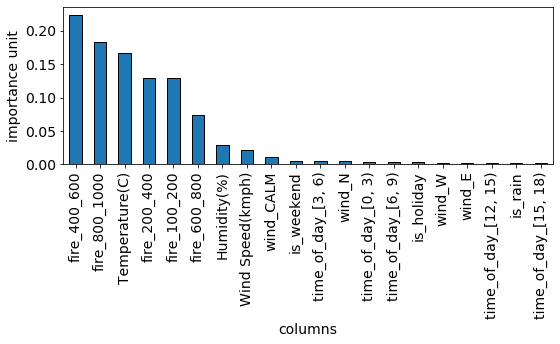

In [97]:
%%time
train_city_s1(city='Bangkok', pollutant= 'PM2.5', op_fire_twice=False, search_wind_damp=False)

In [99]:
dataset, model, fire_cols, zone_list, feat_imp, roll_win = load_model(city='Bangkok', pollutant='PM2.5')

data no fire has shape (53454, 21)
raw model performance {'test_r2_score': 0.4523791275502036, 'test_mean_squared_error': 105.06578233536386, 'test_mean_absolute_error': 7.719021807352131}
daily avg training error {'avg_trn_r2_score': 0.7347259010253706, 'avg_trn_mean_squared_error': 50.550108452129685, 'avg_trn_mean_absolute_error': 5.245735428937645}
daily avg test error {'avg_test_r2_score': 0.5363080126541466, 'avg_test_mean_squared_error': 73.29120032404646, 'avg_test_mean_absolute_error': 6.401300232939831}


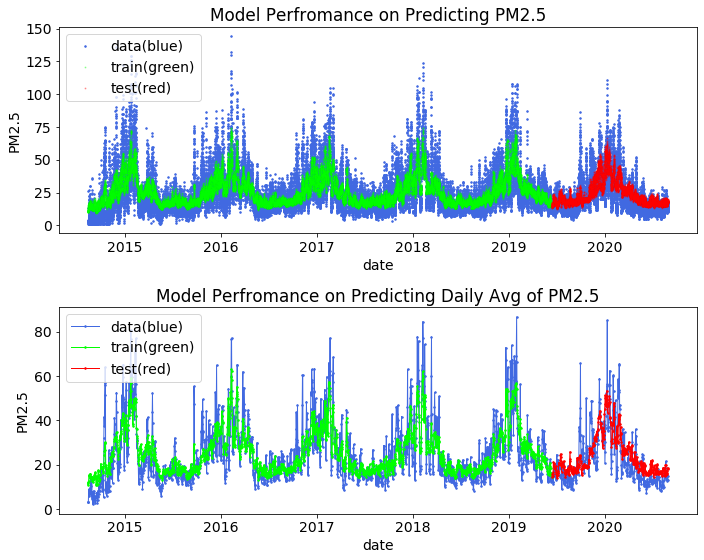

In [100]:
ytrn_pred_df, ytest_pred_df = plot_model_perf(dataset=dataset, model=model, split_list=[0.8, 0.2], xlim=[], to_save=True)

##  Train  PM2.5 with Traffic

data no fire has shape (53472, 22)
=================optimize 1: find the best RF model=================
xtrn has shape (31803, 27)
{'n_estimators': 140, 'min_samples_split': 50, 'min_samples_leaf': 20, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True} 0.285764151124842
val score after op_rf {'val_r2_score': 0.39803722163313693, 'val_mean_squared_error': 122.5423953239608, 'val_mean_absolute_error': 8.293824524328617}
test score after op_rf {'test_r2_score': 0.3965640719574668, 'test_mean_squared_error': 115.74590166965092, 'test_mean_absolute_error': 8.161996147471774}
=================optimize 2: remove unncessary columns=================
old cols length 27
drop time_of_day_[0, 3)
drop wind_W
drop time_of_day_[3, 6)
drop is_weekend
drop wind_N
use columns ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM', 'wind_E', 'wind_S', 'is_rain', 'is_holiday', 'day_of_week', 'time_of_day_[6, 9)', 'time_of_day_[9, 12)', 'time_of_day_[12, 15)', 'time_of_day_[15, 18)', '

{'n_estimators': 140, 'min_samples_split': 10, 'min_samples_leaf': 74, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True} 0.28873965304457194
val score after op6 {'val_r2_score': 0.40815130607685146, 'val_mean_squared_error': 120.5265488319915, 'val_mean_absolute_error': 8.182955660052611}
test score after op6 {'test_r2_score': 0.42854894278324995, 'test_mean_squared_error': 109.63150485741117, 'test_mean_absolute_error': 7.898325197200326}
final score for test set {'test_r2_score': 0.4528885617784738, 'test_mean_squared_error': 104.96804298970638, 'test_mean_absolute_error': 7.708134957383588}
Wall time: 9h 7min 52s


(<src.features.dataset.Dataset at 0x1a416577548>,
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=74,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=140, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False),
 {'rolling_win': 1,
  'cat_hour': True,
  'wind_damp': False,
  'fill_missing': True,
  'group_hour': 3,
  'split_lists': [[0.6, 0.2, 0.2], [0.6, 0.2, 0.2], [0.8, 0.2]],
  'x_cols_org': ['Temperature(C)',
   'Humidity(%)',
   'Wind Speed(kmph)',
   'wind_CALM',
   'wind_E',
   'wind_S',
   'is_rain',
   'is_holiday',
   'day_of_week',
   'time_of_day_[6, 9)',
   'time_of_day_[9, 12)',
   'time_of_day_[12, 15)',
   'time_of_day_[15, 18)',
   

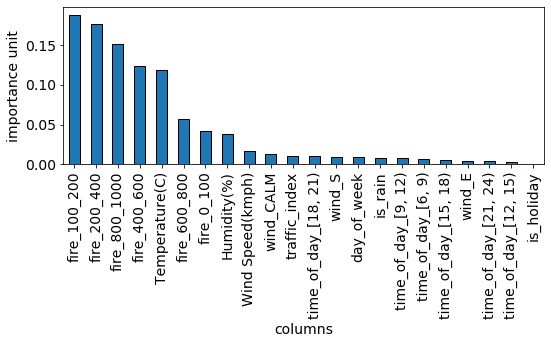

In [8]:
%%time
train_city_s1(city='Bangkok', pollutant= 'PM2.5', op_fire_twice=False, search_wind_damp=False)

## Train PM10

data no fire has shape (172233, 21)
=================optimize 1: find the best RF model=================
xtrn has shape (62695, 26)
{'n_estimators': 120, 'min_samples_split': 20, 'min_samples_leaf': 17, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False} 0.2381990992010113
val score after op_rf {'val_r2_score': 0.03407484289462359, 'val_mean_squared_error': 379.720730469839, 'val_mean_absolute_error': 16.04096067779647}
test score after op_rf {'test_r2_score': 0.18465833414871824, 'test_mean_squared_error': 370.10851669042734, 'test_mean_absolute_error': 15.20058714831314}
=================optimize 2: remove unncessary columns=================
old cols length 26
drop is_rain
drop wind_E
use columns ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM', 'wind_N', 'wind_S', 'wind_W', 'is_holiday', 'is_weekend', 'day_of_week', 'time_of_day_[0, 3)', 'time_of_day_[3, 6)', 'time_of_day_[6, 9)', 'time_of_day_[9, 12)', 'time_of_day_[12, 15)', 'time_of_day_[15, 18)', 'tim

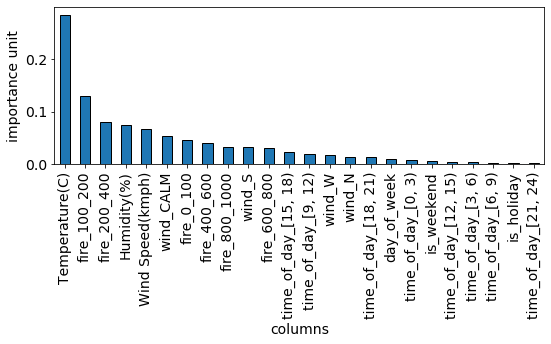

In [2]:
dataset, model, poll_meta = train_city_s1(city= 'Bangkok', pollutant='PM10', search_wind_damp=True)

In [4]:
dataset, model, fire_cols, zone_list, feat_imp, roll_win = load_model(city='Bangkok', pollutant='PM10')

data no fire has shape (172233, 21)
raw model performance {'test_r2_score': 0.2869351053528041, 'test_mean_squared_error': 323.56606671093067, 'test_mean_absolute_error': 13.146837790609498}
daily avg training error {'avg_trn_r2_score': 0.7700699032786738, 'avg_trn_mean_squared_error': 77.42620950821473, 'avg_trn_mean_absolute_error': 6.589591997100774}
daily avg test error {'avg_test_r2_score': 0.3484523203658526, 'avg_test_mean_squared_error': 222.75280852747895, 'avg_test_mean_absolute_error': 10.908293292379689}


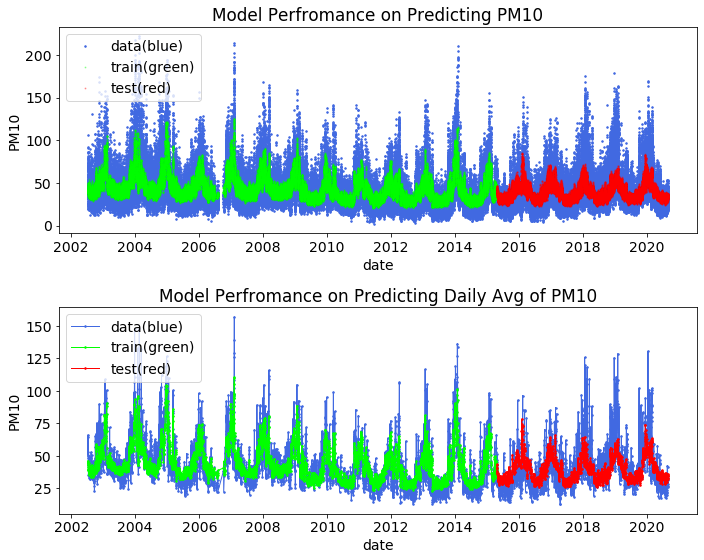

In [5]:
ytrn_pred_df, ytest_pred_df = plot_model_perf(dataset=dataset, model=model, split_list=[0.7, 0.3], xlim=[], to_save=True)

## Train O3

data no fire has shape (172209, 21)
=================optimize 1: find the best RF model=================
xtrn has shape (62495, 26)
{'n_estimators': 160, 'min_samples_split': 50, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True} 0.6406739781088391
val score after op_rf {'val_r2_score': 0.5647507136800312, 'val_mean_squared_error': 106.28863783029428, 'val_mean_absolute_error': 6.856109525274524}
test score after op_rf {'test_r2_score': 0.5326093460650112, 'test_mean_squared_error': 128.25160273950436, 'test_mean_absolute_error': 7.727061154891887}
=================optimize 2: remove unncessary columns=================
old cols length 26
drop is_rain
drop is_holiday
drop day_of_week
drop time_of_day_[3, 6)
drop time_of_day_[18, 21)
use columns ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM', 'wind_E', 'wind_N', 'wind_S', 'wind_W', 'is_weekend', 'time_of_day_[0, 3)', 'time_of_day_[6, 9)', 'time_of_day_[9, 12)', 'time_of_day_[12, 15)', 

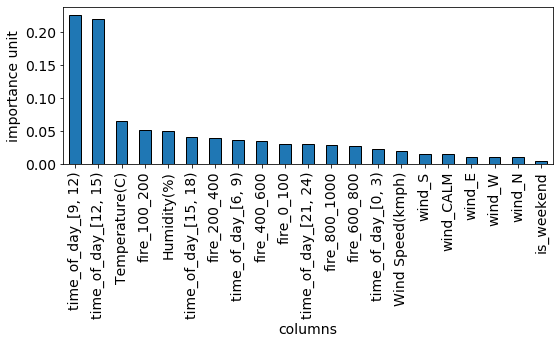

In [6]:
dataset, model, poll_meta = train_city_s1(city= 'Bangkok', pollutant='O3', search_wind_damp=True)

In [7]:
dataset, model, fire_cols, zone_list, feat_imp, roll_win = load_model(city='Bangkok', pollutant='O3')

data no fire has shape (172230, 21)
raw model performance {'test_r2_score': 0.6112849635233042, 'test_mean_squared_error': 106.6595484657536, 'test_mean_absolute_error': 7.016516111004648}
daily avg training error {'avg_trn_r2_score': 0.8059246795575935, 'avg_trn_mean_squared_error': 9.941376710016245, 'avg_trn_mean_absolute_error': 2.3517200641314218}
daily avg test error {'avg_test_r2_score': 0.366585605251024, 'avg_test_mean_squared_error': 47.19135257986454, 'avg_test_mean_absolute_error': 4.945309198819954}


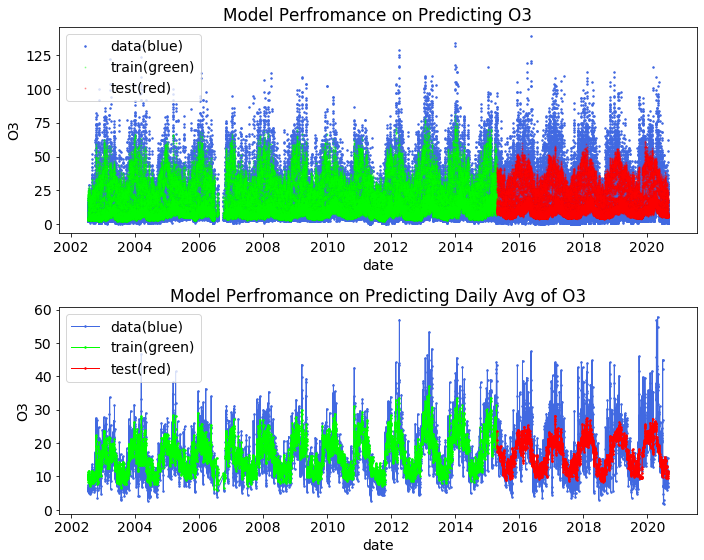

In [8]:
ytrn_pred_df, ytest_pred_df = plot_model_perf(dataset=dataset, model=model, split_list=[0.7, 0.3], xlim=[], to_save=True)

## Train NO2

data no fire has shape (76368, 15)
=================optimize 1: find the best RF model=================
xtrn has shape (30355, 20)
{'n_estimators': 180, 'min_samples_split': 5, 'min_samples_leaf': 11, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True} 0.24231452262225636
val score after op_rf {'val_r2_score': 0.2678307866209485, 'val_mean_squared_error': 111.33738490479391, 'val_mean_absolute_error': 8.114096684719359}
test score after op_rf {'test_r2_score': 0.37417382445746916, 'test_mean_squared_error': 91.7297848588591, 'test_mean_absolute_error': 7.388761190834165}
=================optimize 2: remove unncessary columns=================
old cols length 20
drop is_rain
drop is_weekend
use columns ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM', 'wind_E', 'wind_N', 'wind_S', 'wind_W', 'is_holiday', 'day_of_week', 'time_of_day', 'traffic_index', 'fire_0_100', 'fire_100_200', 'fire_200_400', 'fire_400_600', 'fire_600_800', 'fire_800_1000']
score after dropp

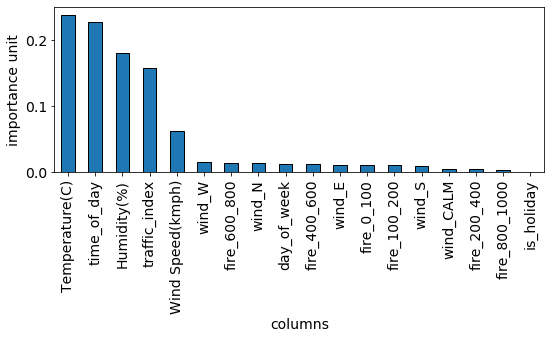

In [9]:
dataset, model, poll_meta = train_city_s1(city= 'Bangkok', pollutant='NO2', default_meta=True, search_wind_damp=True)

In [10]:
dataset, model, fire_cols, zone_list, feat_imp, roll_win = load_model(city='Bangkok', pollutant='NO2')

data no fire has shape (76368, 15)
raw model performance {'test_r2_score': 0.39908662705065867, 'test_mean_squared_error': 89.46213051154928, 'test_mean_absolute_error': 7.021310198462453}
daily avg training error {'avg_trn_r2_score': 0.5881346922691971, 'avg_trn_mean_squared_error': 37.27518473918147, 'avg_trn_mean_absolute_error': 4.615326765673302}
daily avg test error {'avg_test_r2_score': 0.5211911799192189, 'avg_test_mean_squared_error': 46.23947648937689, 'avg_test_mean_absolute_error': 5.3850310969378805}


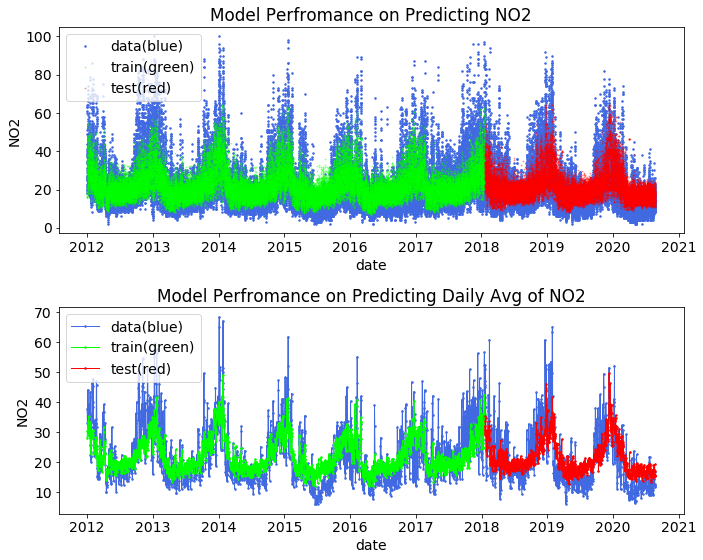

In [11]:
ytrn_pred_df, ytest_pred_df = plot_model_perf(dataset=dataset, model=model, split_list=[0.7, 0.3], xlim=[], to_save=True)

## TPOP PM10

In [ ]:
# implement the best parameters 
fire_col = fire_dict['fire_col']
w_speed = fire_dict['w_speed']
damp_surface = fire_dict['surface']
shift = fire_dict['shift']
roll = fire_dict['roll']
# obtain fire data 
fire_proc, fire_col_list = get_fire_feature(fire, zone_list=[0, 100, 200, 400, 800, 1000], 
fire_col=fire_col,damp_surface=damp_surface, 
shift=shift, roll=roll, w_speed=w_speed)
 
# merge fire data 
data = data_no_fire.merge(fire_proc, left_index=True, right_index=True, how='inner')
data = data.dropna()
 
x_cols = ['Wind Speed(kmph)', 'Temperature(C)', 'Humidity(%)', 'time_of_day',
       'fire_400_800', 'fire_800_1000', 'fire_200_400', 'fire_0_100',
       'fire_100_200', 'PM2.5_lag_1']
xtrn, ytrn, x_cols = get_data_matrix(data, pollutant,trn_idx, x_cols=x_cols)
xval, yval, _ = get_data_matrix(data, pollutant,val_idx, x_cols=x_cols)

In [ ]:
#ask TPOT to hunt for the best model
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2)
tpot.fit(xtrn, ytrn)

In [ ]:
print(tpot.score(xval,yval))
tpot.export(dataset.model_folder+'PM10_tpot_pipeline.py')